In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [4]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<h2>Neural Network</h2>

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

<h1>A2C: Synchronous Advantage Actor Critic</h1>

<p>The Asynchronous Advantage Actor Critic method (A3C) has been very influential since the paper was published. The algorithm combines a few key ideas:</p>

<ul>
    <li>An updating scheme that operates on fixed-length segments of experience (say, 20 timesteps) and uses these segments to compute estimators of the returns and advantage function.</li>
    <li>Architectures that share layers between the policy and value function.</li>
    <li>Asynchronous updates.</li>
</ul>

<p>After reading the paper, AI researchers wondered whether the asynchrony led to improved performance (e.g. “perhaps the added noise would provide some regularization or exploration?“), or if it was just an implementation detail that allowed for faster training with a CPU-based implementation.</p>

<p>As an alternative to the asynchronous implementation, researchers found you can write a synchronous, deterministic implementation that waits for each actor to finish its segment of experience before performing an update, averaging over all of the actors. One advantage of this method is that it can more effectively use of GPUs, which perform best with large batch sizes. This algorithm is naturally called A2C, short for advantage actor critic. (This term has been used in several papers.)</p>

In [7]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [8]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

In [9]:
max_frames   = 20000
frame_idx    = 0
test_rewards = []

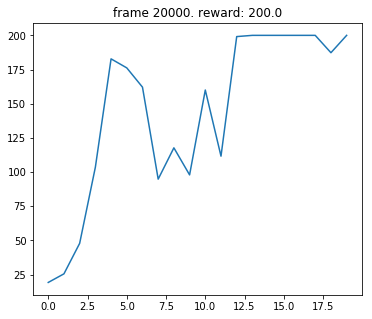

In [10]:
state = envs.reset()

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_returns(next_value, rewards, masks)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)

    advantage = returns - values

    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [12]:
test_env()

200.0